<a href="https://colab.research.google.com/github/NabiAdnan/Lane-Detection-using-VGG---UNet/blob/main/Tusimple_Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
manideep1108_tusimple_path = kagglehub.dataset_download('manideep1108/tusimple')

print('Data source import complete.')

Using Colab cache for faster access to the 'tusimple' dataset.
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [ ]:
IMAGE_FOLDER = "tusimple_processed/images"
MASK_FOLDER = "tusimple_processed/masks"

In [ ]:
def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [ ]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory created: tusimple_processed/images
Directory created: tusimple_processed/masks


### Copy Images to the Image Directory

In [ ]:
CLIPS_PATH = "/kaggle/input/tusimple/TUSimple/train_set/clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        tmp = frame_path[:-7].split('/')[-2:]
        new_filename = f"{tmp[0]}_{tmp[1]}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)

Processing Clip: 0531
Processing Clip: 0601
Processing Clip: 0313-2
Processing Clip: 0313-1


In [ ]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


### Create Masks for the Images

In [ ]:
# load the dataset json files
df1 = pd.read_json("/kaggle/input/tusimple/TUSimple/train_set/label_data_0313.json", lines = True)
df2 = pd.read_json("/kaggle/input/tusimple/TUSimple/train_set/label_data_0531.json", lines = True)
df3 = pd.read_json("/kaggle/input/tusimple/TUSimple/train_set/label_data_0601.json", lines = True)

# combine into single dataframe
df = pd.concat([df1, df2, df3])
df.head()

lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

In [ ]:
# create function for generating masks
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)

    # generate mask filename
    temp = raw_file[:-7].split('/')[-2:]
    mask_filename = f"{temp[0]}_{temp[1]}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [ ]:
# generate masks
for index, row in tqdm(df.iterrows(), total=len(df)):
    generate_lane_mask(row)

  0%|          | 0/3626 [00:00<?, ?it/s]

In [ ]:
print("Total masks in dataset:", len(os.listdir(MASK_FOLDER)))

Total masks in dataset: 3626


# Data Visualization

In [ ]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)

    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)

    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")

    # show the images
    plt.show()

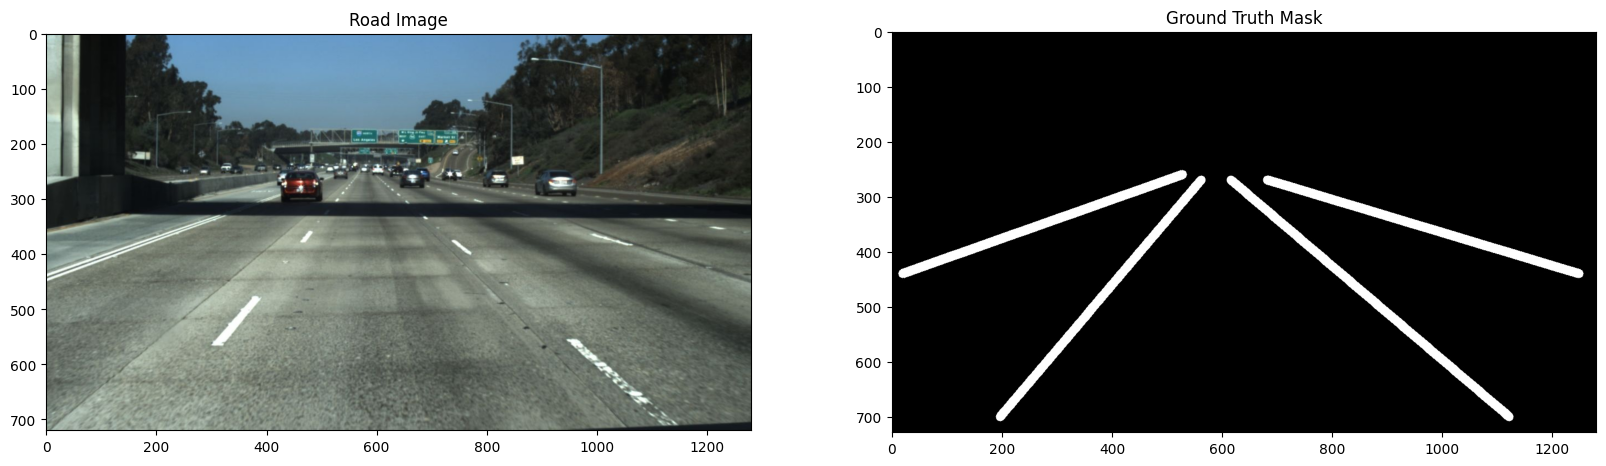

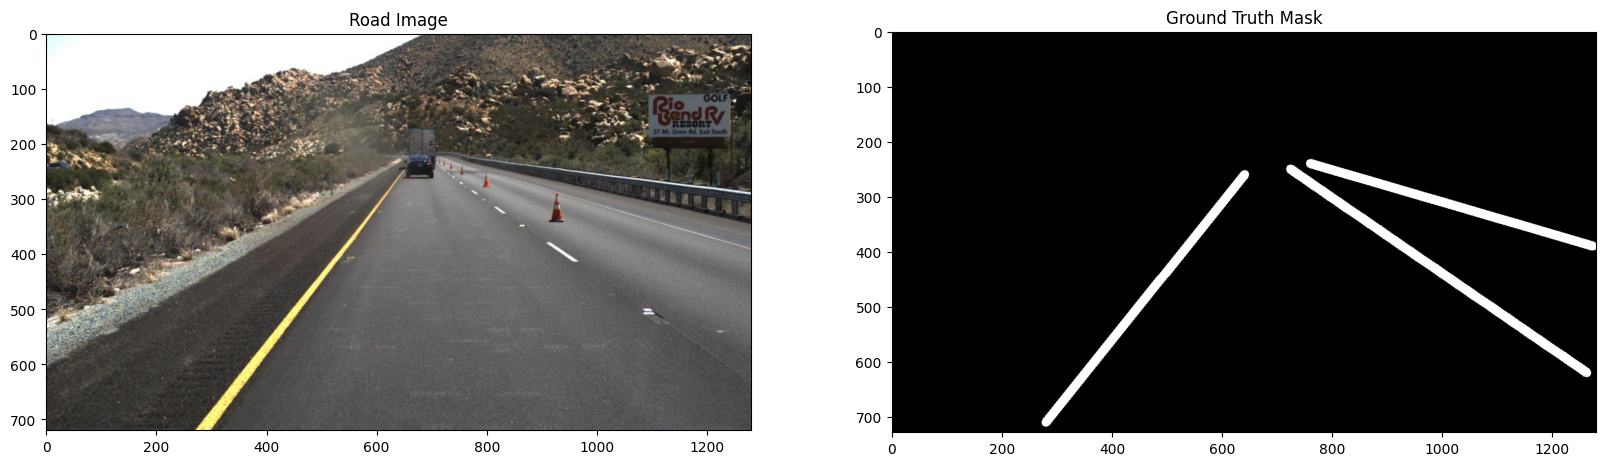

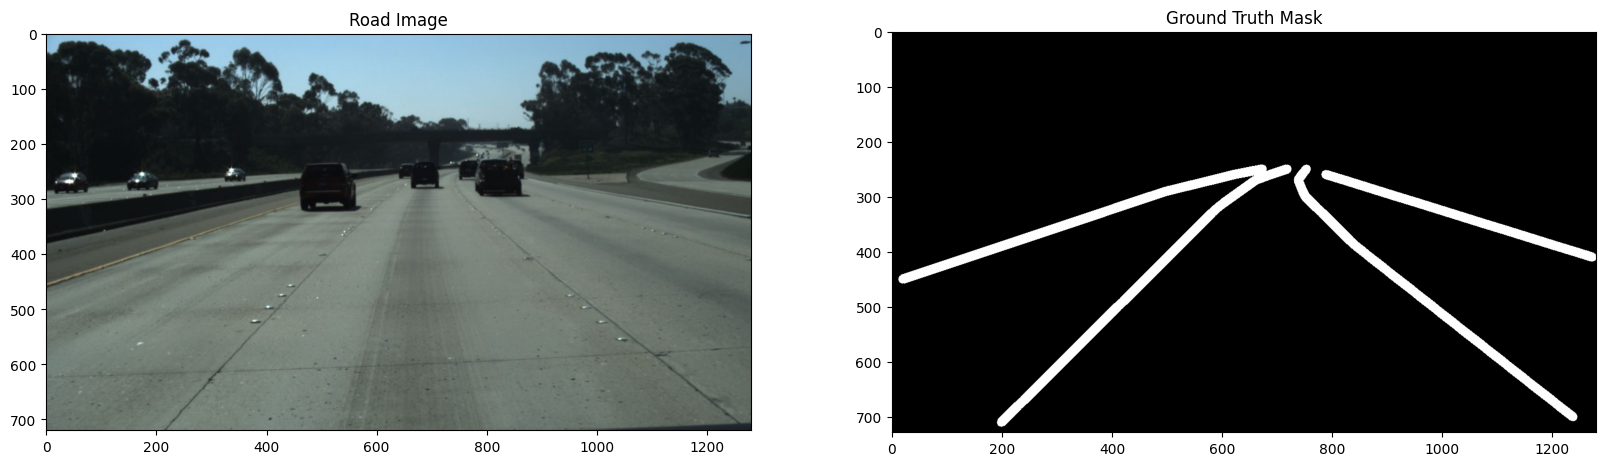

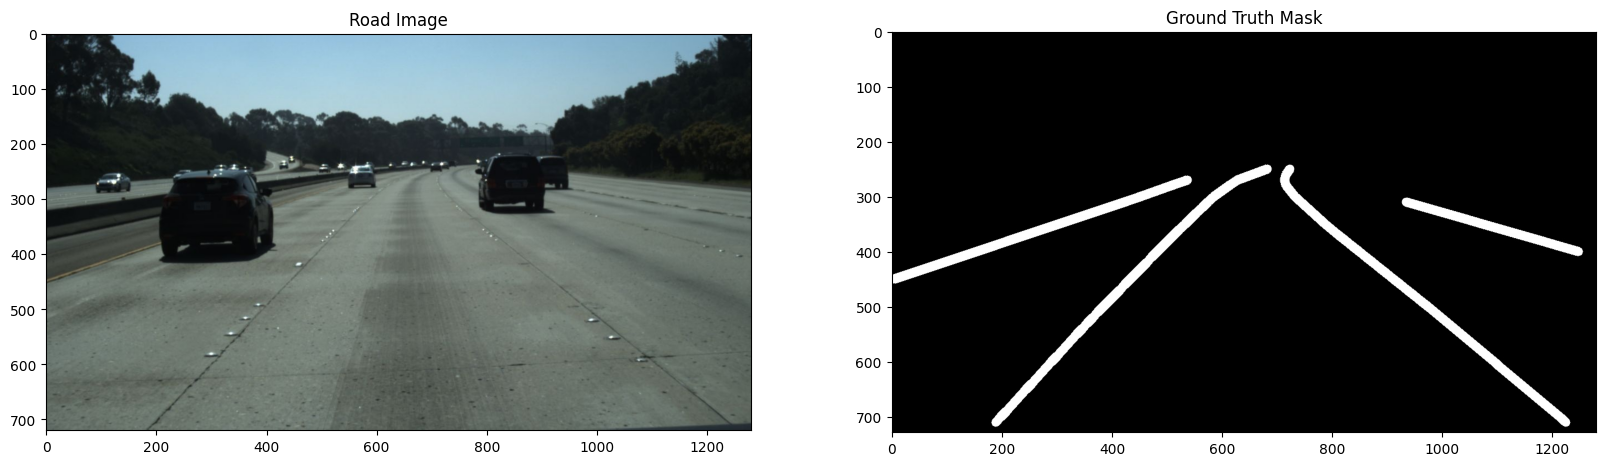

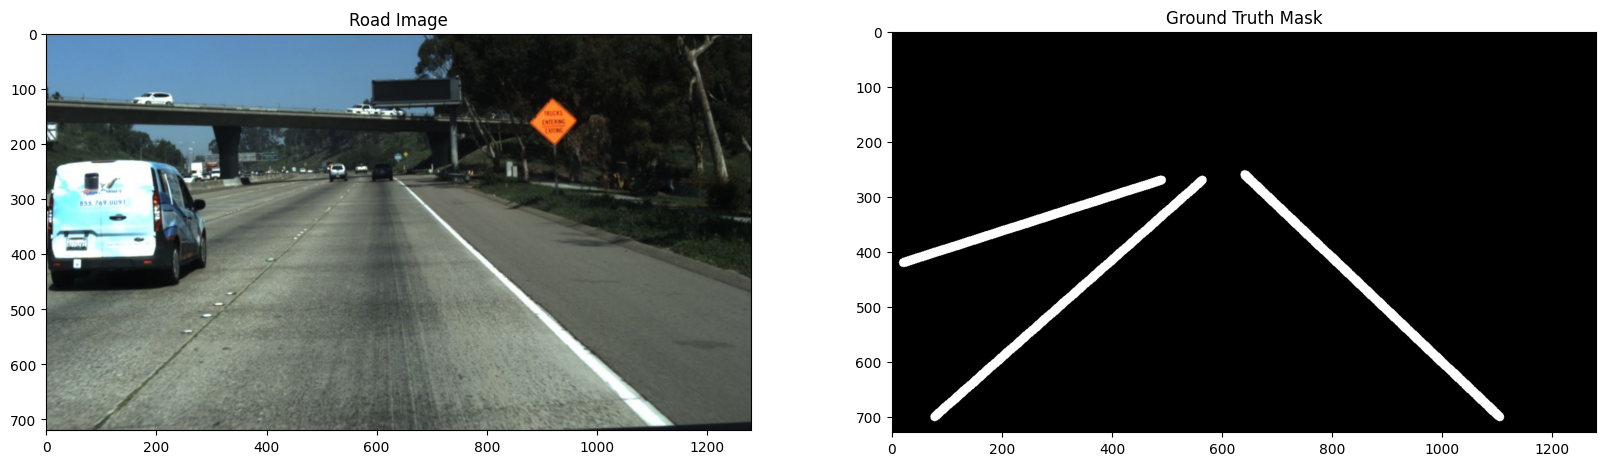

In [ ]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

# Process Data for Training and Testing

In [ ]:
train_image_folder = "tusimple_processed/train/images"
test_image_folder = "tusimple_processed/test/images"
train_mask_folder = "tusimple_processed/train/masks"
test_mask_folder = "tusimple_processed/test/masks"

In [ ]:
for folder_path in [train_image_folder, test_image_folder, train_mask_folder, test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory created: tusimple_processed/train/images
Directory created: tusimple_processed/test/images
Directory created: tusimple_processed/train/masks
Directory created: tusimple_processed/test/masks


In [ ]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for train and test
train_images, test_images = train_test_split(images, test_size=0.1, random_state=42)

In [ ]:
len(train_images), len(test_images)

(3263, 363)

In [ ]:
# move files to the corresponding folders
for file in train_images:
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(train_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(train_mask_folder, file)
    shutil.move(source, destination)

for file in test_images:
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(test_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(test_mask_folder, file)
    shutil.move(source, destination)

## Feature Engineering

In [ ]:
import tensorflow as tf

def load_image(image_path, mask_path):
    size = [224, 224]

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0


    kernel = tf.constant([[0., -1., 0.],
                          [-1., 5., -1.],
                          [0., -1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])

    channels = tf.split(image, num_or_size_splits=3, axis=-1)
    sharpened_channels = []
    for c in channels:
        c_sharp = tf.nn.conv2d(tf.expand_dims(c, axis=0), kernel, strides=1, padding="SAME")
        sharpened_channels.append(tf.squeeze(c_sharp, axis=0))
    image = tf.concat(sharpened_channels, axis=-1)
    image = tf.clip_by_value(image, 0.0, 1.0)


    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask / 255.0

    return image, mask


In [ ]:
def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".jpg")])
    mask_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(".jpg")])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))

    return dataset

In [ ]:
# load dataset from folder
train_dataset = dataset_from_folder(train_image_folder, train_mask_folder)
test_dataset = dataset_from_folder(test_image_folder, test_mask_folder)

In [ ]:
import tensorflow as tf
# 1 GPU CONFIGURATION — must be first before using TF ops

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(e)


# 2 DATASET PIPELINE CONFIG

BATCH_SIZE = 8        # safer for T4
BUFFER_SIZE = 1000

# Example: (assuming train_dataset and test_dataset already exist)
train_dataset = (
    train_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# # set config
# BATCH_SIZE = 16
# BUFFER_SIZE = 1000

# # optimize for performance improvement
# train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
# train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# test_datset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Physical devices cannot be modified after being initialized


In [ ]:
def display_sample(image_list):
    plt.figure(figsize=(10, 10))

    titles = ["Image", "True Mask", "Predicted Mask"]

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis("off")

    plt.show()

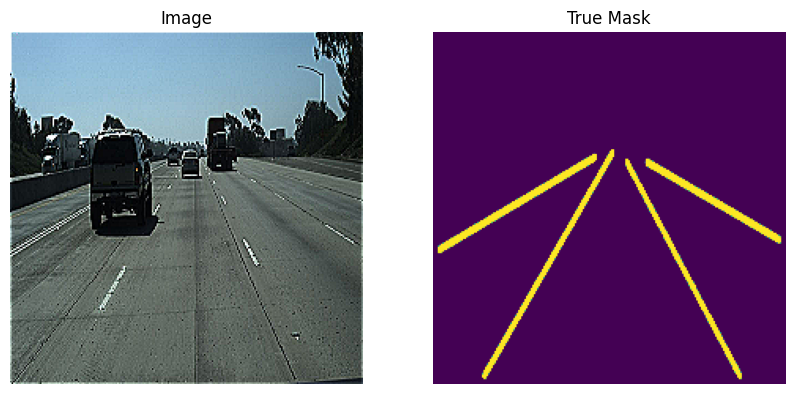

In [ ]:
for image, mask in train_dataset.take(1):
    display_sample([image[0], mask[0]])

# Model Creation - VGG-UNet

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, Concatenate, UpSampling2D
from tensorflow.keras.models import Model

def VGG16_UNet(input_shape=(None, None, 3)):
    '''U net architechture with VGG16 encoder'''
    def Conv2DReluBatchNorm(n_filters, kernel_size, stride, inputs):
        x = Conv2D(n_filters, (1, 1), strides=1,
                   padding="same", kernel_initializer='glorot_normal', activation="elu")(inputs)
        x = Conv2D(n_filters, kernel_size, strides=stride,
                   padding="same", kernel_initializer='glorot_normal', activation="elu")(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True) # traininig + test-time ropout!
        return x

    # VGG16 encoder
    vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Unfreeze VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = True

    # Encoder layers
    inputs = vgg16.input
    layer1 = vgg16.get_layer("block1_conv2").output
    layer2 = vgg16.get_layer("block2_conv2").output
    layer3 = vgg16.get_layer("block3_conv3").output
    layer4 = vgg16.get_layer("block4_conv3").output
    layer5 = vgg16.get_layer("block5_conv3").output

    # Decoder layers
    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2, 2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(512, (3, 3), (1, 1), merge6)

    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2, 2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(256, (3, 3), (1, 1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2, 2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(512, (3, 3), (1, 1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2, 2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(512, (3, 3), (1, 1), merge9)

    output = Conv2D(1, (1, 1), strides=(1, 1), activation="sigmoid", name="output")(layer9)

    return Model(inputs=inputs, outputs=output)

model = VGG16_UNet(input_shape=(224, 224, 3)) # Adjust input shape as needed

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow
from tensorflow.keras import backend as K

def dice_coefficent(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    mu = y_pred[:, :, :, 0]
    y_pred_f = K.flatten(mu)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficent(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))

def precision_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))

def accuracy(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)

    # True positives
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))

    # True negatives
    true_negatives = K.sum(K.round(K.clip((1- y_true_f) * (1 - y_pred_f), 0, 1)))

    # Total pixels
    total_pixels = K.cast(tensorflow.size(y_true_f), K.floatx())

    # Accuracy
    accuracy_value = (true_positives + true_negatives) / total_pixels

    return accuracy_value

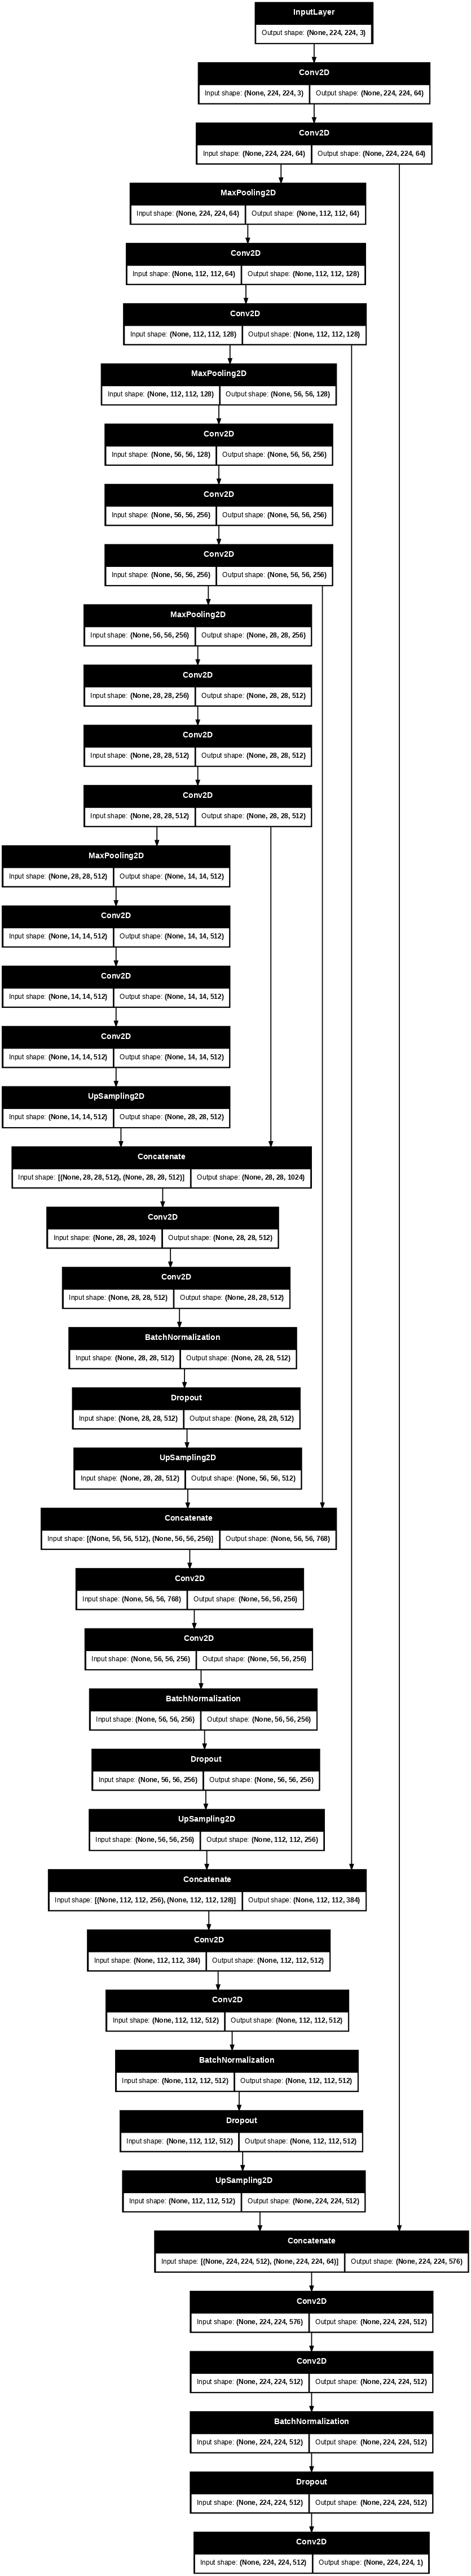

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=64)

In [ ]:
# create mask from prediction
def create_mask(pred_mask):
    # round to closest
    pred_mask = tf.math.round(pred_mask)
    return pred_mask

def show_predictions(dataset=None, num=1):
    if dataset:
        for images, masks in dataset.take(num):
            pred_mask = model.predict(images)
            pred_mask = create_mask(pred_mask[0])
            display_sample([images[0], masks[0], pred_mask])

1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step


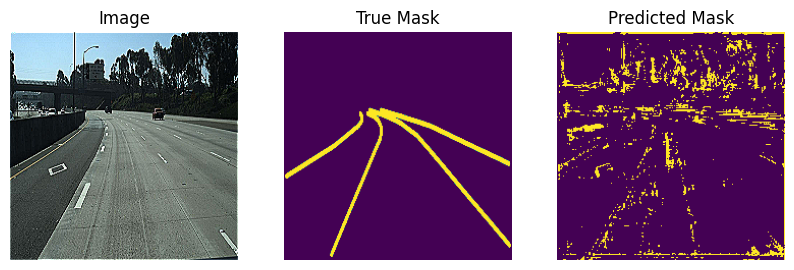

In [ ]:
show_predictions(train_dataset, 1)

In [ ]:
# callbacks and logs
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback
import datetime

class DisplayCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(test_dataset, 1)
        print(f"Sample Prediction after epoch {epoch}\n")

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    DisplayCallback(),
    TensorBoard(logdir, histogram_freq=-1),
    EarlyStopping(patience=5, verbose=1),
    ModelCheckpoint("best_model.keras", verbose=1, save_best_only=True)
]

In [ ]:
EPOCHS = 10
steps_per_epoch = len(os.listdir(train_image_folder)) // BATCH_SIZE
validation_steps = len(os.listdir(test_image_folder)) // BATCH_SIZE

# Train the Model

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


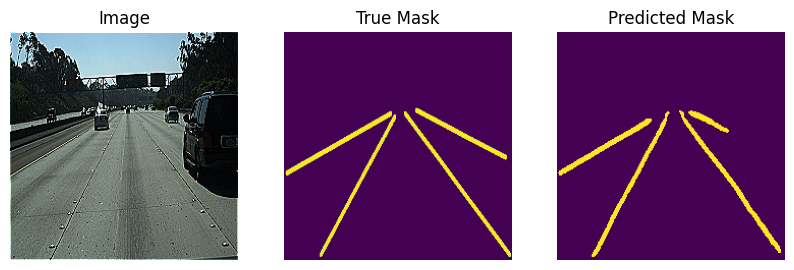

Sample Prediction after epoch 0


Epoch 1: val_loss improved from inf to 0.32772, saving model to best_model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.9150 - loss: 0.5264 - precision_smooth: 0.6131 - recall_smooth: 0.6131 - val_accuracy: 0.9743 - val_loss: 0.3277 - val_precision_smooth: 0.6312 - val_recall_smooth: 0.6312
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


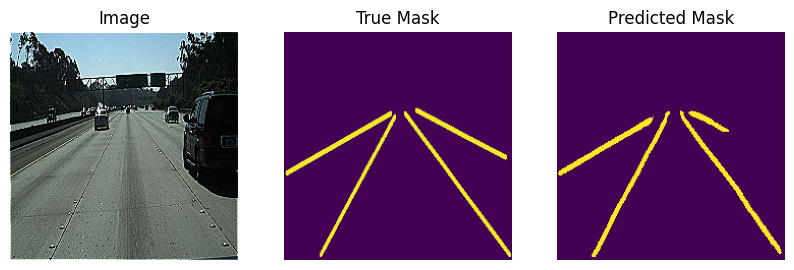

Sample Prediction after epoch 1


Epoch 2: val_loss improved from 0.32772 to 0.32724, saving model to best_model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 147s 83ms/step - accuracy: 0.9651 - loss: 0.4032 - precision_smooth: 0.5900 - recall_smooth: 0.5900 - val_accuracy: 0.9741 - val_loss: 0.3272 - val_precision_smooth: 0.6350 - val_recall_smooth: 0.6350
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


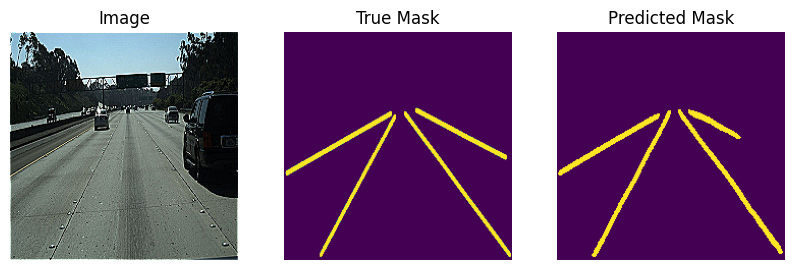

Sample Prediction after epoch 2


Epoch 3: val_loss improved from 0.32724 to 0.28437, saving model to best_model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.9742 - loss: 0.3011 - precision_smooth: 0.7061 - recall_smooth: 0.7061 - val_accuracy: 0.9753 - val_loss: 0.2844 - val_precision_smooth: 0.7375 - val_recall_smooth: 0.7375
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


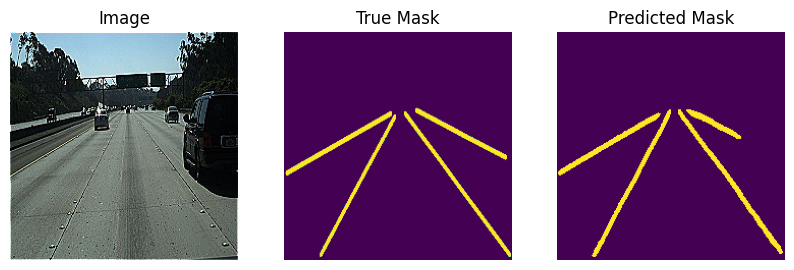

Sample Prediction after epoch 3


Epoch 4: val_loss improved from 0.28437 to 0.28183, saving model to best_model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.9729 - loss: 0.3014 - precision_smooth: 0.7230 - recall_smooth: 0.7230 - val_accuracy: 0.9752 - val_loss: 0.2818 - val_precision_smooth: 0.7494 - val_recall_smooth: 0.7494
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


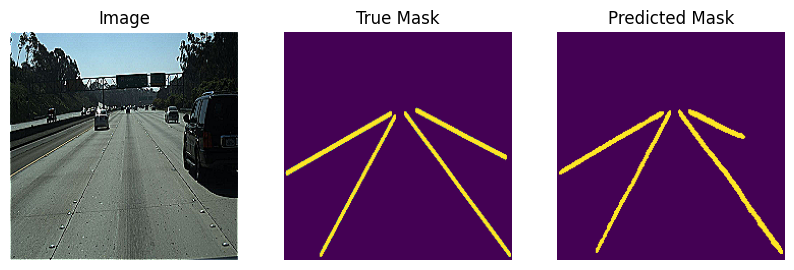

Sample Prediction after epoch 4


Epoch 5: val_loss did not improve from 0.28183
407/407 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.9767 - loss: 0.2702 - precision_smooth: 0.7457 - recall_smooth: 0.7457 - val_accuracy: 0.9761 - val_loss: 0.2913 - val_precision_smooth: 0.6927 - val_recall_smooth: 0.6927
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


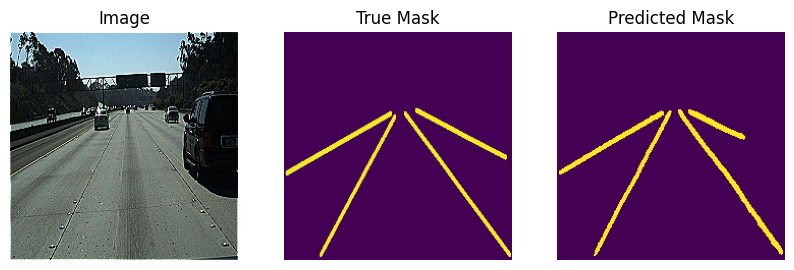

Sample Prediction after epoch 5


Epoch 6: val_loss improved from 0.28183 to 0.27774, saving model to best_model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9729 - loss: 0.2936 - precision_smooth: 0.7191 - recall_smooth: 0.7191 - val_accuracy: 0.9766 - val_loss: 0.2777 - val_precision_smooth: 0.7245 - val_recall_smooth: 0.7245
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


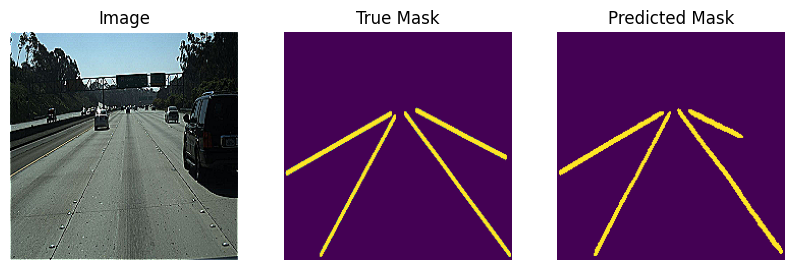

Sample Prediction after epoch 6


Epoch 7: val_loss improved from 0.27774 to 0.26090, saving model to best_model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.9779 - loss: 0.2551 - precision_smooth: 0.7656 - recall_smooth: 0.7656 - val_accuracy: 0.9778 - val_loss: 0.2609 - val_precision_smooth: 0.7457 - val_recall_smooth: 0.7457
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


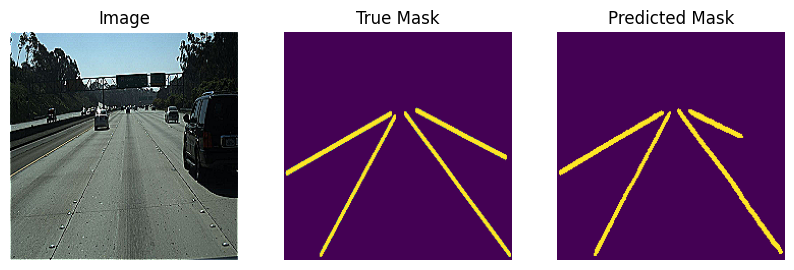

Sample Prediction after epoch 7


Epoch 8: val_loss improved from 0.26090 to 0.25693, saving model to best_model.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.9776 - loss: 0.2483 - precision_smooth: 0.7368 - recall_smooth: 0.7368 - val_accuracy: 0.9781 - val_loss: 0.2569 - val_precision_smooth: 0.7507 - val_recall_smooth: 0.7507
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


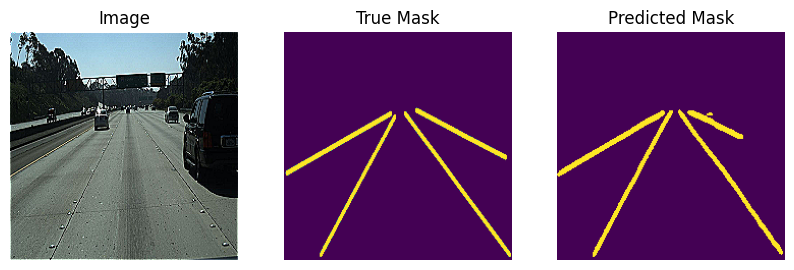

Sample Prediction after epoch 8


Epoch 9: val_loss did not improve from 0.25693
407/407 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.9788 - loss: 0.2438 - precision_smooth: 0.7773 - recall_smooth: 0.7773 - val_accuracy: 0.9768 - val_loss: 0.2610 - val_precision_smooth: 0.7793 - val_recall_smooth: 0.7793
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


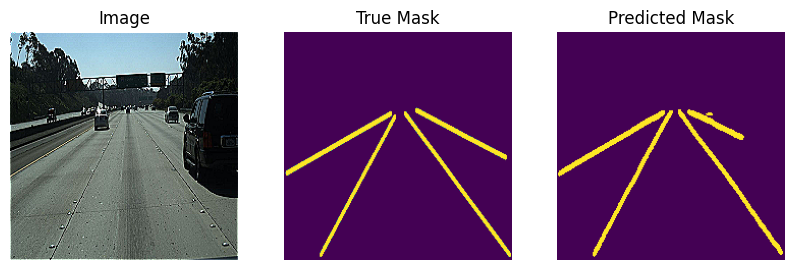

Sample Prediction after epoch 9


Epoch 10: val_loss did not improve from 0.25693
407/407 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.9759 - loss: 0.2620 - precision_smooth: 0.7435 - recall_smooth: 0.7435 - val_accuracy: 0.9771 - val_loss: 0.2570 - val_precision_smooth: 0.7862 - val_recall_smooth: 0.7862


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

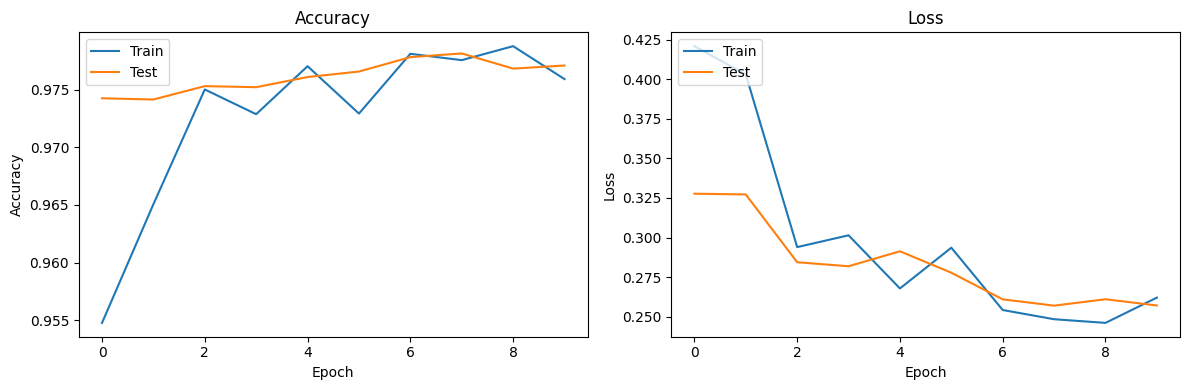

In [ ]:


# plot train and val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")

# plot train and val loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")

plt.tight_layout()
plt.savefig("training_history.svg")
plt.show()

## Load the Best Model

In [ ]:
best_model = tf.keras.models.load_model(
    "best_model.keras",
    custom_objects={
        "dice_loss": dice_loss,
        "dice_coefficent": dice_coefficent,
        "precision_smooth": precision_smooth,
        "recall_smooth": recall_smooth,
        "accuracy": accuracy
    }
)
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 70,811,077 (270.12 MB)

 Trainable params: 23,602,497 (90.04 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 47,204,996 (180.07 MB)

## Test Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


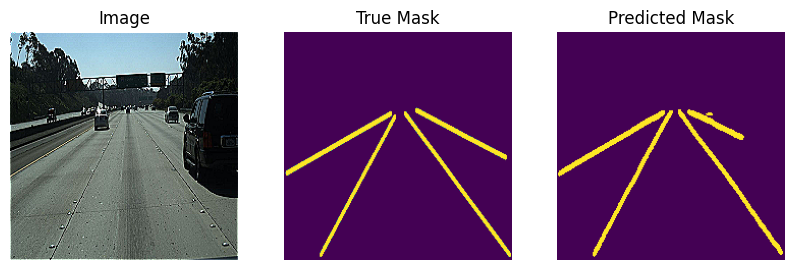

✅ Prediction plot saved: prediction_plots/prediction_0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


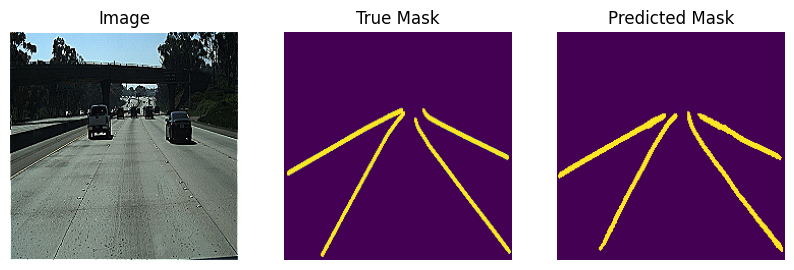

✅ Prediction plot saved: prediction_plots/prediction_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


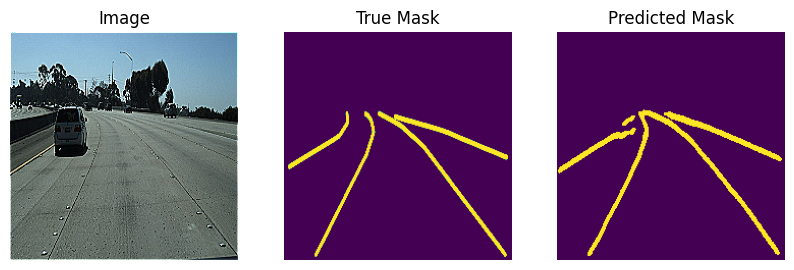

✅ Prediction plot saved: prediction_plots/prediction_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


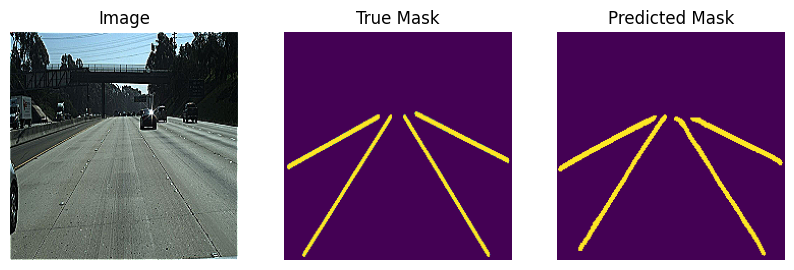

✅ Prediction plot saved: prediction_plots/prediction_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


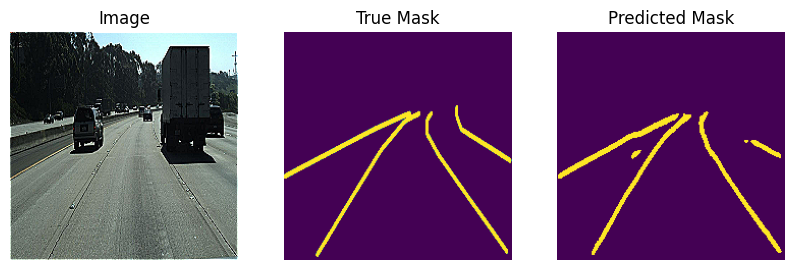

✅ Prediction plot saved: prediction_plots/prediction_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


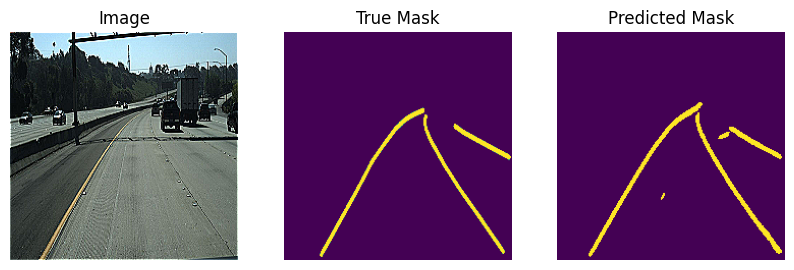

✅ Prediction plot saved: prediction_plots/prediction_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


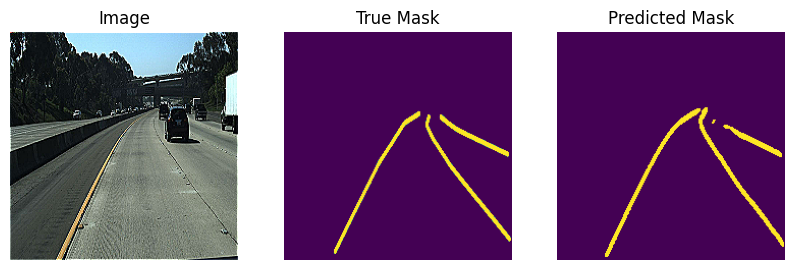

✅ Prediction plot saved: prediction_plots/prediction_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


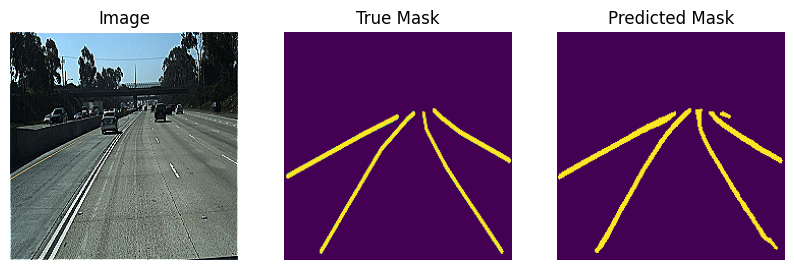

✅ Prediction plot saved: prediction_plots/prediction_7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


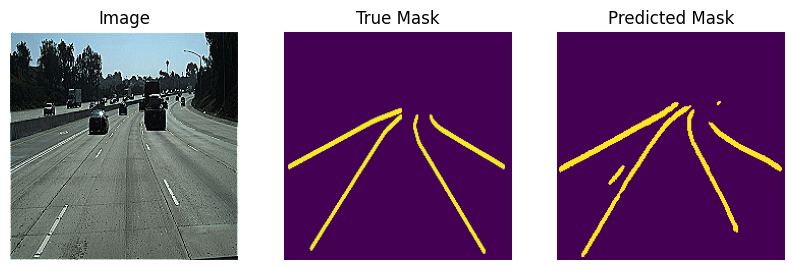

✅ Prediction plot saved: prediction_plots/prediction_8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


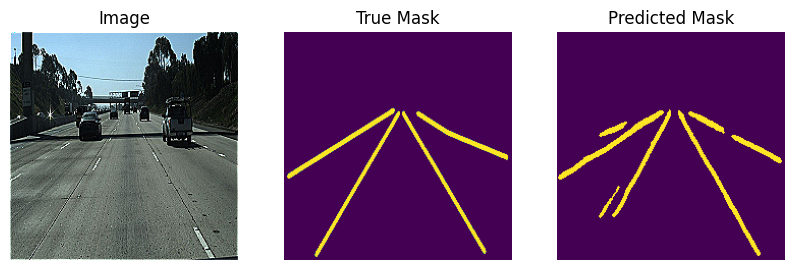

✅ Prediction plot saved: prediction_plots/prediction_9.png


In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def save_prediction_plot(image_list, index=0, save_dir="prediction_plots"):
    os.makedirs(save_dir, exist_ok=True)
    titles = ["Image", "True Mask", "Predicted Mask"]

    plt.figure(figsize=(10, 10))
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        plt.imshow(array_to_img(image_list[i]))
        plt.axis("off")

    filepath = os.path.join(save_dir, f"prediction_{index}.png")
    plt.savefig(filepath)
    plt.close()
    print(f"✅ Prediction plot saved: {filepath}")

def show_and_save_predictions(dataset=None, num=1, save_dir="prediction_plots"):
    if dataset:
        os.makedirs(save_dir, exist_ok=True)
        for i, (images, masks) in enumerate(dataset.take(num)):
            pred_mask = model.predict(images)
            pred_mask = create_mask(pred_mask[0])
            display_sample([images[0], masks[0], pred_mask])
            save_prediction_plot([images[0], masks[0], pred_mask], index=i, save_dir=save_dir)

show_and_save_predictions(test_dataset, 10)

## Test from Image Path

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files  # Works in Colab;
from PIL import Image
import numpy as np

# --- Function to load and sharpen test image ---
def load_test_image(image_path_or_bytes):
    size = [224, 224]

    if isinstance(image_path_or_bytes, str):  # file path
        image = tf.io.read_file(image_path_or_bytes)
    else:  # uploaded file bytes
        image = image_path_or_bytes

    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0  # normalize to [0, 1]

    # Sharpening kernel
    kernel = tf.constant([[0., -1., 0.],
                          [-1., 5., -1.],
                          [0., -1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])

    # Apply kernel to each channel
    channels = tf.split(image, num_or_size_splits=3, axis=-1)
    sharpened_channels = []
    for c in channels:
        c_sharp = tf.nn.conv2d(tf.expand_dims(c, axis=0), kernel, strides=1, padding="SAME")
        sharpened_channels.append(tf.squeeze(c_sharp, axis=0))
    image = tf.concat(sharpened_channels, axis=-1)
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

In [ ]:
# --- Function to create overlay ---
def create_overlay(image, mask, alpha=0.5, color=[1.0, 0.0, 0.0]):
    """Overlay mask in given color (default red)."""
    if mask.shape[-1] == 1:
        mask_colored = mask * color
    else:
        mask_colored = mask
    overlay = image * (1 - alpha) + mask_colored * alpha
    return tf.clip_by_value(overlay, 0.0, 1.0)


# --- Display function ---
def display_test_sample(image_list, titles=None):
    plt.figure(figsize=(15, 5))

    if titles is None:
        titles = ["Image", "Predicted Mask", "Overlay"]

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis("off")

    plt.show()

 Please upload an image for testing:


Saving Screenshot 2025-10-30 213622.png to Screenshot 2025-10-30 213622 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


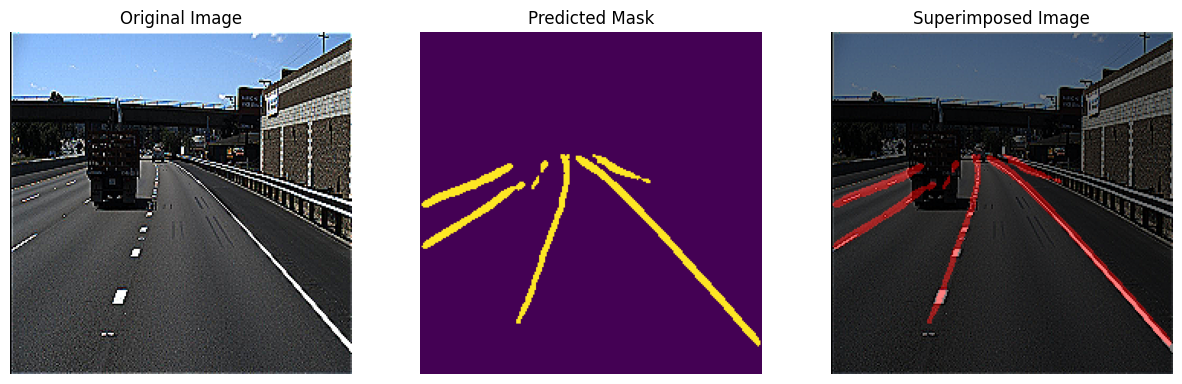

In [ ]:
# --- Choose Image Option ---
print(" Please upload an image for testing:")
uploaded = files.upload()  # Opens a file picker

# Get the uploaded file (works for single file upload)
for filename, filedata in uploaded.items():
    image_bytes = tf.convert_to_tensor(filedata)
    image = load_test_image(image_bytes)

    # Expand dimensions for model prediction
    test_image = tf.expand_dims(image, axis=0)

    # --- Model Inference ---
    pred_mask = model.predict(test_image)
    pred_mask = create_mask(pred_mask[0])  # Assuming you have this function defined

    # --- Create Overlay ---
    overlay = create_overlay(image, pred_mask, alpha=0.5)

    # --- Display Results ---
    display_test_sample(
        [image, pred_mask, overlay],
        titles=["Original Image", "Predicted Mask", "Superimposed Image"]
    )